# **Project Title**
#### *Project Subtitle*

## Hypothesis;

Project thesis

In [ ]:
# Importing dependencies
import pandas as pd

# **Data**

## Dataset

Dataset details

In [ ]:
# Reading in data
# (potentially?)

### EDA

In [ ]:
# Beginning EDA

# **Ramona's Code Space**

*End Code Space*

# **Christian's Code Space**

### Dependencies

In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

#### Resources path

In [3]:
### Main Path
path = os.getcwd()+'\\Resources'

business_dataset = path+'\\yelp_academic_dataset_business.json'
checkin_dataset  = path +'\\yelp_academic_dataset_checkin.json'
reviews_dataset  = path + '\\yelp_academic_dataset_review.json'
tip_dataset      = path + '\\yelp_academic_dataset_tip.json'
user_dataset     = path + '\\yelp_academic_dataset_user.json'

---

#### Business dataset

#### <font color='blue'> Description:</font> 
**Contains business data including location data, attributes, and categories.**

In [10]:
with open(business_dataset, "r",encoding = 'utf8') as f:
    business_df = pd.read_json(f, orient="records", lines=True,)

In [11]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


#### Info

In [13]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


---

#### Checkin dataset

#### <font color='blue'> Description:</font>
**Checkins on a business.**

In [24]:
with open(checkin_dataset, "r",encoding = 'utf8') as f:
    checkin_df = pd.read_json(f, orient="records", lines=True,)

In [25]:
checkin_df.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [26]:
checkin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


#### **<font color='orange'> Notes:</font>**
**The team has determined this dataset would not add any value to our training data.**

---

#### Reviews dataset

#### <font color = 'blue'>Description:</font>
**Contains full review text data including the user_id that wrote the review and the business_id the review is written for.**

In [37]:
chunk_list = []
with open(reviews_dataset, "r",encoding = 'utf8') as f:
    reviews_reader = pd.read_json(f, orient="records", lines=True,chunksize=10000)

    for chunk in reviews_reader:
        chunk_list.append(chunk)

In [38]:
reviews_df = pd.concat(chunk_list, ignore_index=True)
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [39]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 480.0+ MB


#### Na count

In [41]:
reviews_df.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

#### Dropping columns:
- **review_id**
- **useful**
- **funny**
- **cool**

In [162]:
reviews_df.drop(columns = ['review_id','useful','funny','cool'],
                inplace = True)

#### Renaming the 'text' field to 'review'

In [165]:
reviews_df.rename(columns = {'text':'review'},inplace = True)
reviews_df.head()

,user_id,business_id,stars,review,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


#### **<font color='orange'> Notes:</font>**
- **review_id: Eliminated due to low informational value.**
- **useful: Eliminated due to low relevance.**
- **funny: Eliminated due to low relevance.**
- **cool: Eliminated due to low relevance.**

  **The *<font color='green'>'business_id'</font>* feature will be used as the identifier, *<font color='green'>'stars'</font>* is the rating metric and the *<font color='grey'>'review'</font>*  field encapsulates**<br>
  **the data to be processed. the *<font color='green'>'date'</font>* variable is in place if time series analysis is needed.**

---

#### Tips dataset

#### <font color='blue'>Description:</font>
**Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.**

In [58]:
with open(tip_dataset, "r",encoding = 'utf8') as f:
    tips_df = pd.read_json(f, orient="records", lines=True,)

In [59]:
tips_df.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


#### Info

In [63]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           908915 non-null  object        
 1   business_id       908915 non-null  object        
 2   text              908915 non-null  object        
 3   date              908915 non-null  datetime64[ns]
 4   compliment_count  908915 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.7+ MB


#### Dropping columns:
- **compliment_count**

In [172]:
tips_df.drop(columns = ['compliment_count'],
             inplace =True)

#### Renaming the 'text' column to 'recommendations'

In [175]:
tips_df.rename(columns = {'text':'recommendations'},inplace = True)
tips_df.head()

,user_id,business_id,recommendations,date
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09


#### **<font color='orange'> Notes:</font>**
- **compliment_count: Eliminated due to low informational value.**


 **Since this data set has recommendations from the user to improve customer experience the 'recommendations' field could be a useful target variable.**

---

#### User dataset

#### <font color = 'blue'>Note:</font>
**User data including the user's friend mapping and all the metadata associated with the user.**

In [76]:
user_list = []
with open(user_dataset, "r",encoding = 'utf8') as f:
    user_reader = pd.read_json(f, orient="records", lines=True,chunksize=10000)

    for chunk in user_reader:
        user_list.append(chunk)

In [77]:
user_df = pd.concat(user_list, ignore_index=True)
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


#### Info

In [79]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 333.7+ MB


#### **<font color='orange'> Notes:</font>**
**This data set will not be included in the training data to preserve user anonimity.**

# //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

#### <font color = 'blue'>Description:</font>
**This data set contains the fields that will be used to train the model**

In [241]:
data_df = reviews_df.merge(business_df,how='left',on = 'business_id')

In [243]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   user_id       object        
 1   business_id   object        
 2   stars_x       int64         
 3   review        object        
 4   date          datetime64[ns]
 5   name          object        
 6   address       object        
 7   city          object        
 8   state         object        
 9   postal_code   object        
 10  latitude      float64       
 11  longitude     float64       
 12  stars_y       float64       
 13  review_count  int64         
 14  is_open       int64         
 15  attributes    object        
 16  categories    object        
 17  hours         object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(11)
memory usage: 960.0+ MB


In [245]:
data_df.head()

,user_id,business_id,stars_x,review,date,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,748 W Starr Pass Blvd,Tucson,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,2549 Banks St,New Orleans,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


#### Na count

In [248]:
data_df.isna().sum()

user_id              0
business_id          0
stars_x              0
review               0
date                 0
name                 0
address              0
city                 0
state                0
postal_code          0
latitude             0
longitude            0
stars_y              0
review_count         0
is_open              0
attributes      183723
categories         689
hours           398286
dtype: int64

In [249]:
na_prcnt = data_df[['attributes','categories','hours']].isna().sum()/data_df.shape[0]*100
nas_df = pd.DataFrame(na_prcnt, columns=['percentage'])
nas_df = nas_df.transpose()
nas_df

,attributes,categories,hours
percentage,2.628264,0.009857,5.697712


Text(0.5, 1.0, 'Na percentage')

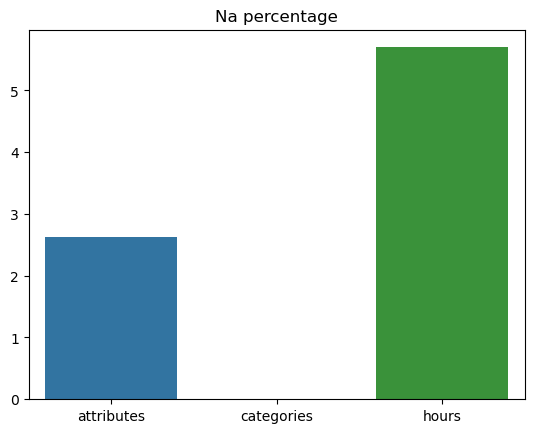

In [250]:
sns.barplot(data = nas_df).set_title('Na percentage')

#### **<font color='orange'> Notes:</font>**
**Due to the low percentage of na counts for each feature recommend dropping the rows.**

#### *<font color='grey'>stars_x* and *<font color='grey'>stars_y* comparison

In [254]:
data_df.loc[data_df['stars_x'] != data_df['stars_y']][['stars_x','stars_y']].head()

,stars_x,stars_y
2,3,3.5
3,5,4.0
5,1,4.0
6,5,4.5
7,5,3.5


#### *<font color='grey'>stars_x* and *<font color='grey'>stars_y*  for the same customer

In [256]:
data_df.loc[data_df['business_id']=='XQfwVwDr-v0ZS3_CbbE5Xw'][['stars_x','stars_y']].head()

,stars_x,stars_y
0,3,3.0
6080,2,3.0
6911,4,3.0
6927,3,3.0
13378,2,3.0


#### *<font color='grey'>stars_x* average

In [258]:
round(data_df.loc[data_df['business_id']=='XQfwVwDr-v0ZS3_CbbE5Xw']['stars_x'].mean(),2)

3.07

#### **<font color='orange'> Notes:</font>**
**Because** *<font color='grey'> star_y</font>* **represents the average star rating, renaming** *<font color='grey'> star_y:</font>* **to:** *<font color='grey'> star_avg:</font>*

In [261]:
data_df.rename(columns={'stars_y':'stars_avg','stars_x':'stars'},inplace = True)

In [264]:
data_df.head()

,user_id,business_id,stars,review,date,name,address,city,state,postal_code,latitude,longitude,stars_avg,review_count,is_open,attributes,categories,hours
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,748 W Starr Pass Blvd,Tucson,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,2549 Banks St,New Orleans,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


# //////////////////////////////////////////////////////////////////////////////////////////////////

#### <font color = 'blue'>Description:</font>
**Contains customer recommendatins to improve experience**

In [271]:
tips_df.head()

,user_id,business_id,recommendations,date
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09


In [273]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          908915 non-null  object        
 1   business_id      908915 non-null  object        
 2   recommendations  908915 non-null  object        
 3   date             908915 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 27.7+ MB


#### Quantity of unique business_id in the tips data set

In [281]:
display(tips_df['business_id'].unique().shape[0])

106193

#### Quantity of unique business_id in  data_df

In [283]:
data_df['business_id'].unique().shape[0]

150346

#### Subset of *<font color='grey'>business_id</font>* in *<font color='grey'>data_df</font>* not found in *<font color='grey'>tips_df</font>*.

In [286]:
no_tips_df = data_df[~data_df['business_id'].isin(tips_df['business_id'])]
no_tips_df.head()

,user_id,business_id,stars,review,date,name,address,city,state,postal_code,latitude,longitude,stars_avg,review_count,is_open,attributes,categories,hours
33,yFuE8SPF-d1GXJUWYgKtzg,X8lfGPagfLzfOsx0k08NRQ,5,Took my vehicle here for some work a few years...,2017-05-13 14:15:29,Landa Muffler & Brake,816 E 4th St,Reno,NV,89512,39.531787,-119.802696,3.5,29,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Smog Check Stations, Auto Parts &...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
54,dKoIp8vsKFH4cbmGSYy2IQ,0ICfbEImE0gUZc4kSZ7QHg,5,Replaced 2 old 70s lennox with 2 new ones. Th...,2013-11-14 04:58:09,Reliance The Furnace Company,8545 Coronet Road,Edmonton,AB,T6E 4N7,53.499624,-113.456746,2.5,27,1,None,"Contractors, Home Services, Plumbing, Water Pu...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
56,IMd3NQbclta91pFKk3AJZg,qO9dNNIvNbCBd8ZgjxMxgQ,5,"Farmhouse, rustic, chic.Helpful staff with gre...",2017-04-08 00:33:11,HOME Santa Barbara,14 Parker Way,Santa Barbara,CA,93101,34.414912,-119.694171,4.5,13,1,"{'WheelchairAccessible': 'True', 'BikeParking'...","Home & Garden, Furniture Stores, Home Decor, S...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
76,B6G4f3UX1Z5_CpyV1xXm8Q,AgbRp5NLsP1-J1fdg6Hdcw,5,Awesome little shop. The owner really knows h...,2017-05-13 17:15:09,Hands On Bicycle,1453 Gulf To Bay Blvd,Clearwater,FL,33755,27.963000,-82.777749,5.0,13,1,"{'BusinessParking': '{'garage': False, 'street...","Sporting Goods, Bikes, Shopping","{'Monday': '6:0-17:0', 'Tuesday': '6:0-17:0', ..."
86,XN1ms_EBRYMF5GYSjfUHDQ,rJzLJL33mFyrM_90kAQKuw,5,I'm so incredibly happy with our pictures! Ang...,2017-12-02 18:40:48,Angela Clifton Photography,18205 Atherstone Trl,Land O Lakes,FL,34638,28.208604,-82.516107,5.0,9,1,{'BusinessAcceptsCreditCards': 'True'},"Event Photography, Session Photography, Art Sc...","{'Monday': '10:0-17:0', 'Tuesday': '10:0-17:0'..."


#### Number of *<font color='grey'>business_id</font>* in *<font color='grey'>data_df</font>* not found in *<font color='grey'>tips_df</font>*.

In [289]:
no_tips_df = data_df[~data_df['business_id'].isin(tips_df['business_id'])]
not_found = no_tips_df['business_id'].unique().shape[0]
print(f'Number of business_ids in tips_df not found in data_df: {not_found}')

Number of business_ids in tips_df not found in data_df: 44153


#### Evidence

In [293]:
tips_df.loc[tips_df['business_id'] == no_tips_df['business_id'].iloc[33]]

,user_id,business_id,recommendations,date


#### Merge

In [298]:
test_df = pd.merge(tips_df,data_df,
                   on = ['business_id','user_id'],
                   how = 'inner')
                         

#### Overview

In [300]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440640 entries, 0 to 440639
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          440640 non-null  object        
 1   business_id      440640 non-null  object        
 2   recommendations  440640 non-null  object        
 3   date_x           440640 non-null  datetime64[ns]
 4   stars            440640 non-null  int64         
 5   review           440640 non-null  object        
 6   date_y           440640 non-null  datetime64[ns]
 7   name             440640 non-null  object        
 8   address          440640 non-null  object        
 9   city             440640 non-null  object        
 10  state            440640 non-null  object        
 11  postal_code      440640 non-null  object        
 12  latitude         440640 non-null  float64       
 13  longitude        440640 non-null  float64       
 14  stars_avg        440

In [302]:
test_df.head()

,user_id,business_id,recommendations,date_x,stars,review,date_y,name,address,city,state,postal_code,latitude,longitude,stars_avg,review_count,is_open,attributes,categories,hours
0,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,2,Do not get the schezuan chicken. 1) it's not b...,2018-05-08 01:31:54,Wok Out Restaurant,"1444 S Belcher Rd, Ste B",Clearwater,FL,33764,27.943694,-82.746285,3.5,59,1,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,1,"So sad.....the menu is the same, but the taste...",2015-09-26 21:28:21,Siam Cuisine,265 White Bridge Pike,Nashville,TN,37209,36.143308,-86.858303,4.0,153,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Thai","{'Monday': '0:0-0:0', 'Tuesday': '16:30-21:0',..."
2,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,4,Yummie...best thai food in the west side of Na...,2013-11-16 13:28:55,Siam Cuisine,265 White Bridge Pike,Nashville,TN,37209,36.143308,-86.858303,4.0,153,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Thai","{'Monday': '0:0-0:0', 'Tuesday': '16:30-21:0',..."
3,trf3Qcz8qvCDKXiTgjUcEg,7Rm9Ba50bw23KTA8RedZYg,"Chili Cup + Single Cheeseburger with onion, pi...",2012-03-13 04:00:52,4,Bottom Line: All your typical Steak n' Shake ...,2010-10-23 21:32:13,Steak ’n Shake,1300 Lemay Ferry Rd,St. Louis,MO,63125,38.531844,-90.288109,2.0,23,0,"{'RestaurantsGoodForGroups': 'True', 'Alcohol'...","American (Traditional), Burgers, Diners, Ameri...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
4,SMGAlRjyfuYu-c-22zIyOg,kH-0iXqkL7b8UXNpguBMKg,"Saturday, Dec 7th 2013, ride Patco's Silver Sl...",2013-12-03 23:42:15,4,"Patco (sometimes referred to as the ""High Spee...",2013-12-02 13:24:17,PATCO,901 Berlin Rd N,Lindenwold,NJ,08021,39.834038,-75.000662,3.5,74,1,None,"Travel Services, Hotels & Travel, Transportati...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


#### Comparison review vs. recommendations

In [316]:
test_df[['review','recommendations']].head()

,review,recommendations
0,Do not get the schezuan chicken. 1) it's not b...,Very decent fried chicken
1,"So sad.....the menu is the same, but the taste...",Appetizers.. platter special for lunch
2,Yummie...best thai food in the west side of Na...,Appetizers.. platter special for lunch
3,Bottom Line: All your typical Steak n' Shake ...,"Chili Cup + Single Cheeseburger with onion, pi..."
4,"Patco (sometimes referred to as the ""High Spee...","Saturday, Dec 7th 2013, ride Patco's Silver Sl..."


#### **<font color='orange'> Notes:</font>**
**The <font color='grey'>data_df</font> has approximately <font color='green'>7 million</font> entries and <font color='grey'>tips_df</font> about <font color='green'>1 million</font> after merging them we end up the a little under half a million**.<br>
**In the comparison above I don't see a difference between a review from the *reviews data set* and a recommendation from the *tips data set*, as**<br>
**above we stand to loose a significant amount of data if a merge is performed**.

*End Code Space*

# **Leigh's Code Space**

*End Code Space*

# **Angelica's Code Space**

*End Code Space*

# **Odele's Code Space**

*End Code Space*

# **Vanessa's Code Space**

*End Code Space*

# **Train Test Splitting**

# **Scaling and Encoding**

# **Modeling**

# **Application (?)**

# **Findings**

# **Citations and Licenses**

## Citations

## Licenses